<b> <font size="+2.5"> Differential expression analysis using dreamlet
 </b> </font> <br>

Date: 2023-11-21 <br>
Author: ASF

In [ ]:
# see github code from:
# https://github.com/GabrielHoffman/dreamlet_analysis
# https://bioconductor.org/packages/devel/bioc/vignettes/dreamlet/inst/doc/dreamlet.html 

# Load libraries

In [1]:
suppressPackageStartupMessages({
library(SingleCellExperiment)
library(zellkonverter)
library(dreamlet)
library(zenith)
library(DelayedArray)
library(GSEABase)
library(cowplot)
library(tidyverse)
library(kableExtra)
library(qvalue)
library(scattermore)
library(RColorBrewer)
library(corrplot)
library(viridis)
library(dplyr)
library(org.Hs.eg.db)
library(EnrichmentBrowser)
library(ggrepel)
library(rhdf5)
library(HDF5Array)
library(gridExtra)
library(grid)
library(readxl)
library(writexl)
library(rstatix)
library(ggplot2)
library(mashr)
})

# Read in anndata object and make pseudobulk

## read h5ad file

In [2]:
file <- "../datasets/adata_celltypes_after_manual_curation_20231120.h5ad"
sce <- readH5AD(file, use_hdf5=TRUE, verbose=FALSE)

Warning message:
“The names of these selected uns items have been modified to match R
conventions: '6-Batch_colors' -> 'X6.Batch_colors'”
Warning message:
“'X' matrix does not support transposition and has been skipped”
Warning message:
“The names of these selected obs columns have been modified to match R
conventions: '6-Batch' -> 'X6.Batch'”


In [3]:
#formating

# Set missing RIN to median
sce$RIN[is.na(sce$RIN)] = median(sce$RIN, na.rm=TRUE) 

sce$Status <- as.factor(as.character(sce$Status))
sce$Status <- factor(sce$Status, c('0','1'))

sce$X6.Batch <- as.character(sce$X6.Batch)

sce$Disease_Status <- ifelse(sce$Status=='0', 'Controls', 'Cases')
sce$Disease_Status <- factor(sce$Disease_Status, levels=c('Controls', 'Cases'))

In [4]:
sce

class: SingleCellExperiment 
dim: 26195 787685 
metadata(27): X6.Batch_colors Main.Batch_colors ... sample_colors umap
assays(3): X counts sct_corrected
rownames(26195): AL627309.1 AL627309.5 ... AC007325.4 AC007325.2
rowData names(14): gene_ids mito ... dispersions_norm varm
colnames(787685): AAACCCACAATCTCTT-1-0-0 AAACCCAGTAGCTAAA-1-0-0 ...
  TTTGTTGTCAGCTTCC-1-91-90 TTTGTTGTCGACCCAG-1-91-90
colData names(71): sample individual ... major_celltypes Disease_Status
reducedDimNames(2): X_pca X_umap
mainExpName: NULL
altExpNames(0):

## compute pseudobulk

In [5]:
# counts here should represent the raw counts
pb <- aggregateToPseudoBulk(sce,
    assay = "counts",     
    cluster_id = "celltypes_final",  
    sample_id = "sample", 
    BPPARAM = SnowParam(6, progressbar=TRUE))

In [6]:
# read in PC1_hidden_noise
PC1 <- read_xlsx(path = "../datasets/PC1_hidden_confounders.xlsx")
#this table needs to be in the same order (individual) as colData
# check: 
unique(colData(pb)$individual == PC1$individual)

[1] TRUE

In [7]:
pb$PC1 <- PC1$PC1_hidden_noise
#pb@colData
#pb

# Summarize the data

In [8]:
# cell type order
ctorder <- c('Exc_L2-3','Exc_L3-5','Exc_L4-6_1','Exc_L4-6_2', 'Exc_L4-6_3', 'Exc_L5-6_1', 'Exc_L5-6_2', 'Exc_L5-6_HTR2C', 
            'In_LAMP5_1','In_LAMP5_2', 'In_PVALB_Ba','In_PVALB_Ch','In_RELN','In_SST','In_VIP','Astro_FB','Astro_PP','Endothelial',
            'Microglia','Oligodendrocyte', 'OPC')

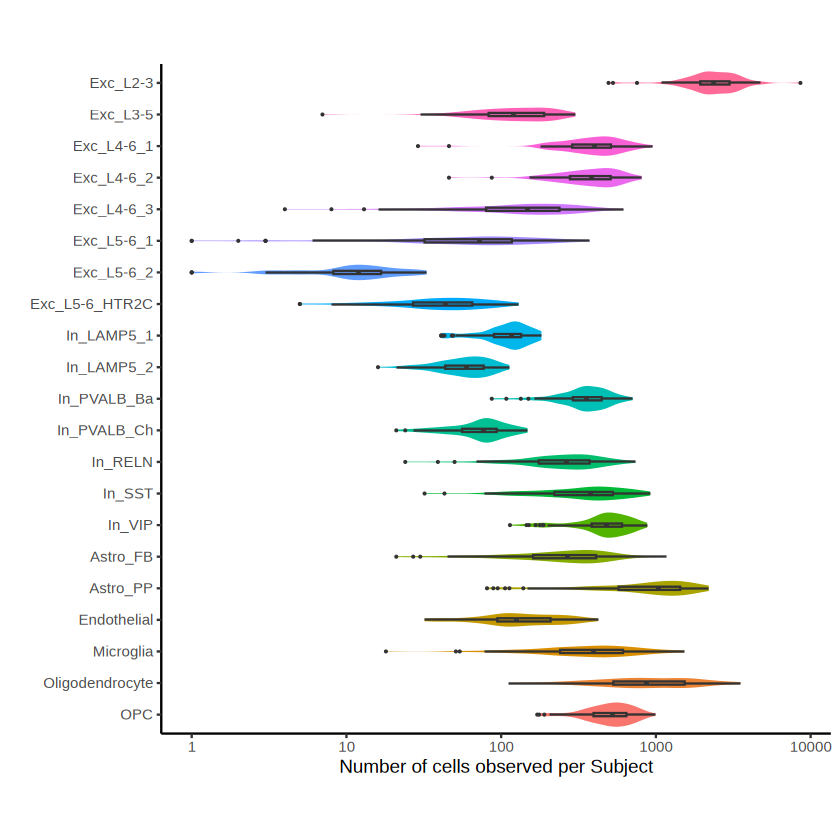

In [9]:
# Number of cells observed per Subject
options(warn=-1)
fig.cells_subject = colData(sce) %>%
  xtabs( ~ sample + celltypes_final,.) %>%
  as_tibble %>%
  pivot_longer(cols=sample) %>%
  mutate(subclass = factor(celltypes_final, rev(ctorder))) %>%  
  ggplot(aes(subclass, n, fill=subclass)) + 
    geom_violin(color = NA) + 
    geom_boxplot(width=.1, outlier.size=.1) +
    theme_classic() + 
    theme(aspect.ratio=1, plot.title = element_text(hjust = 0.5),
      legend.position="none") + 
    scale_y_log10() +
    coord_flip() +
    ylab("Number of cells observed per Subject") +
    xlab('')
fig.cells_subject

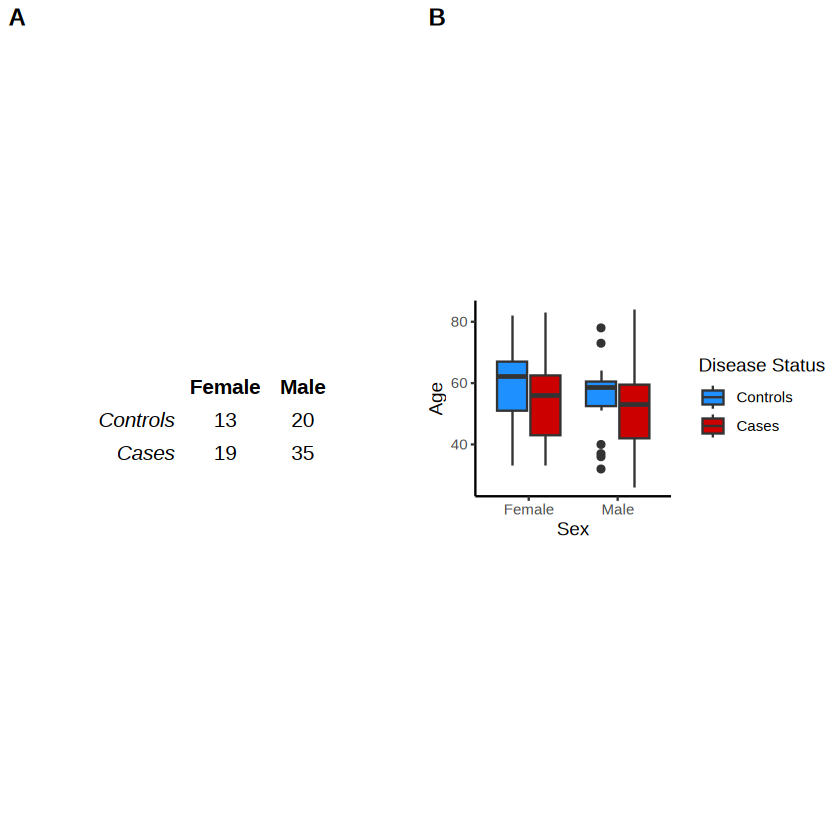

In [10]:
# Summarize demographics
df <- colData(pb) %>%
  as_tibble %>%
  select(individual, Disease_Status, Sex, Age) %>%
  distinct

#xtabs( ~ Disease_Status + Sex, df)

figB <- df %>%
  ggplot(aes(Sex, Age, fill=Disease_Status)) +
    geom_boxplot() + 
    theme_classic() +
    theme(aspect.ratio=1) +
    scale_fill_manual("Disease Status", values = c("dodgerblue", "red3"))

t1 <- tableGrob(xtabs( ~ Disease_Status + Sex, df), theme = ttheme_minimal())
fig <- plot_grid(t1, figB, ncol = 2, labels=LETTERS)
fig

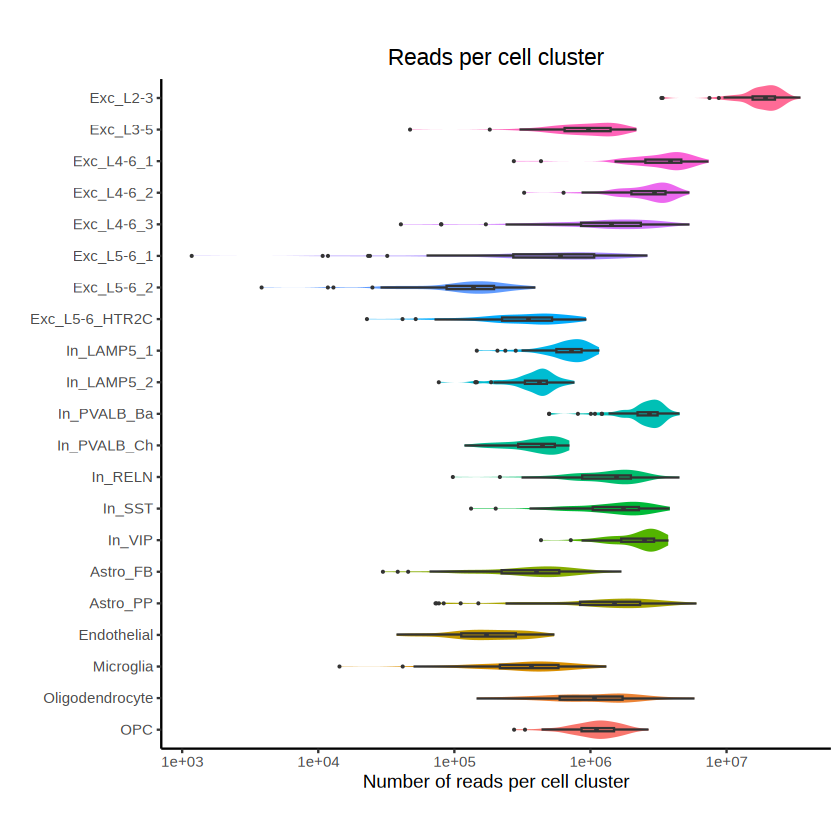

In [11]:
## Summarize read counts
df_counts <- lapply( assayNames(pb), function(x){
  data = assay(pb, x)

  data.frame(celltype = x, ID = colnames(data), readCounts = colSums(data))
})
df_counts <- do.call(rbind, df_counts)
df_counts$celltype = factor(df_counts$celltype, rev(ctorder))  

ggplot(df_counts, aes(celltype, readCounts, fill=celltype)) +  
    geom_violin(color = NA) + 
    geom_boxplot(width=.1, outlier.size=.1) +
    theme_classic() + 
    theme(aspect.ratio=1, plot.title = element_text(hjust = 0.5),
      legend.position="none") + 
    scale_y_log10() +
    coord_flip() +
    ylab("Number of reads per cell cluster") +
    xlab('') +
    ggtitle('Reads per cell cluster')

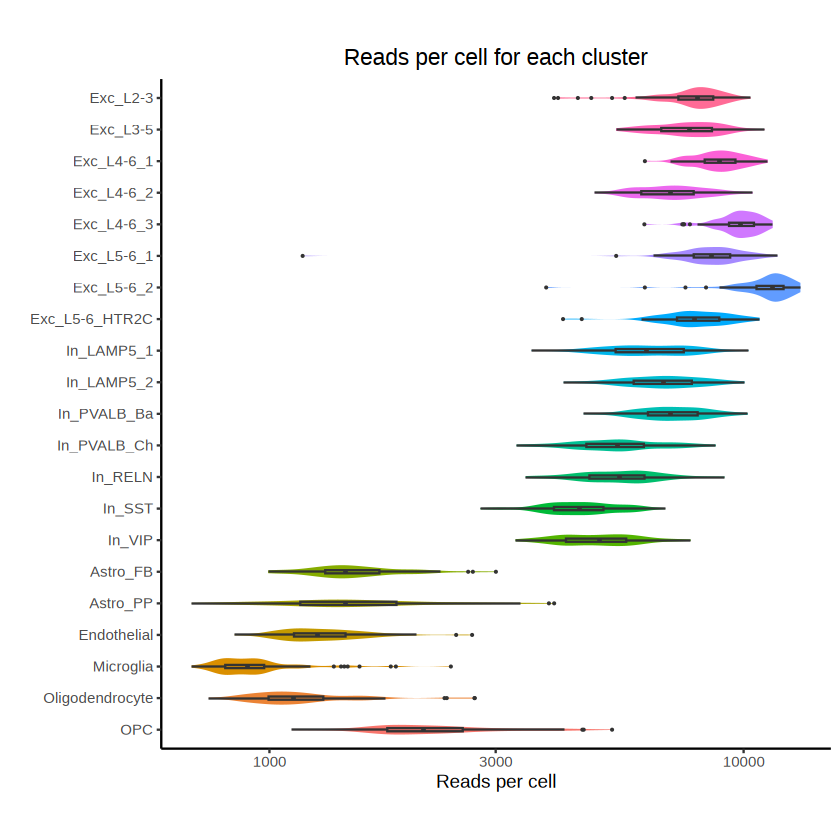

In [12]:
# extract cell counts
df_rate <- cellCounts(pb) %>%
            as.data.frame %>%
            mutate(ID = rownames(.))  %>% 
            pivot_longer(cols=-ID, values_to="ncells", names_to="celltype") %>%
            mutate(celltype = factor(celltype, rev(ctorder)))

# plot reads per cell
inner_join(df_counts, df_rate, by=c("celltype", "ID")) %>%
  ggplot(aes(celltype, readCounts/ncells, fill=celltype)) +  
    geom_violin(color = NA) + 
    geom_boxplot(width=.1, outlier.size=.1) +
    theme_classic() + 
    theme(aspect.ratio=1, plot.title = element_text(hjust = 0.5),
          legend.position="none") + 
    scale_y_log10() +
    coord_flip() +
    ylab('Reads per cell') +
    xlab('') +
    ggtitle('Reads per cell for each cluster')

## Fig. 1c

In [13]:
# extract nuclei counts per individual per cell type
nuclei_counts_per_individual <- cellCounts(pb) %>%
            as.data.frame
nuclei_counts_per_individual$sample <- rownames(nuclei_counts_per_individual)
nuclei_counts_per_individual$individual <- str_extract(nuclei_counts_per_individual$sample, "(?<=SU).*(?=_PFC_RNA)")
nuclei_counts_per_individual$sample <- NULL

nuclei_counts_per_individual <- nuclei_counts_per_individual %>%
  select('individual', everything())

#head(nuclei_counts_per_individual)

#write_xlsx(nuclei_counts_per_individual, "../datasets/nuclei_counts_per_individual_20231121.xlsx",
#col_names = TRUE)

In [14]:
library(readxl)
nuclei_counts_per_individual <- read_excel("../datasets/nuclei_counts_per_individual_20231121.xlsx")
head(nuclei_counts_per_individual)[,2:22]

Exc_L2-3,Exc_L3-5,Exc_L4-6_1,Exc_L4-6_2,Exc_L4-6_3,Exc_L5-6_1,Exc_L5-6_2,Exc_L5-6_HTR2C,In_LAMP5_1,In_LAMP5_2,⋯,In_PVALB_Ch,In_RELN,In_SST,In_VIP,Astro_FB,Astro_PP,Endothelial,Microglia,Oligodendrocyte,OPC
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3117,189,737,598,282,93,32,74,182,100,⋯,135,504,677,861,567,2197,356,714,1311,833
3372,63,369,339,187,108,13,47,105,52,⋯,57,328,635,605,339,1189,186,380,3278,341
2349,218,767,595,432,292,23,107,159,70,⋯,88,357,481,505,409,1460,105,511,2731,587
2129,47,206,205,23,9,6,14,67,26,⋯,55,212,334,354,243,1035,185,247,508,354
1151,84,348,326,58,41,11,36,120,63,⋯,83,230,264,550,392,1745,94,510,112,667
2260,54,366,264,63,42,11,14,144,87,⋯,109,539,705,878,419,1053,125,1521,1083,373


In [15]:
# calculate total number of nuclei for each cell type
nuclei_counts_per_individual$individual <- NULL
n_nuclei_per_celltype <- as.data.frame(colSums(nuclei_counts_per_individual))
n_nuclei_per_celltype$celltype <- rownames(n_nuclei_per_celltype)
colnames(n_nuclei_per_celltype)[1] <- 'n_nuclei'

n_nuclei_per_celltype <- n_nuclei_per_celltype[order(n_nuclei_per_celltype$celltype), ]

# add cell type specific color
n_nuclei_per_celltype$color <- c('#BCAC9B', '#DDC9B4','#6e4c3c', '#2B3A67', '#588157', '#A3B18A', '#2A3D45', '#496A81',
            '#66999B',  '#748b97', '#727D71', '#C17C74', '#dab2ad', '#E26D5C','#EA8C55', '#781F19',
            '#723D46','#472D30','#7A6C5D', '#FFE1A8','#FFC482')

# order same as dotplot (Fig1d)
dotplot_order <- rev(c('Astro_FB','Astro_PP', 'Endothelial', 'Microglia', 'Oligodendrocyte', 'OPC', 
                       'In_PVALB_Ba', 'In_PVALB_Ch','In_LAMP5_1','In_LAMP5_2', 'In_SST', 'In_RELN', 'In_VIP',
                       'Exc_L3-5', 'Exc_L4-6_2',  'Exc_L2-3', 'Exc_L4-6_1', 'Exc_L4-6_3', 'Exc_L5-6_HTR2C', 'Exc_L5-6_1', 
                       'Exc_L5-6_2'))

n_nuclei_per_celltype$celltype <- factor(n_nuclei_per_celltype$celltype, levels=dotplot_order)
n_nuclei_per_celltype <- n_nuclei_per_celltype[order(n_nuclei_per_celltype$celltype), ]


# make label (1000 -> k)
n_nuclei_per_celltype$label <- round((n_nuclei_per_celltype$n_nuclei/1000), digits=1)
n_nuclei_per_celltype$label <- paste0(n_nuclei_per_celltype$label, 'k')

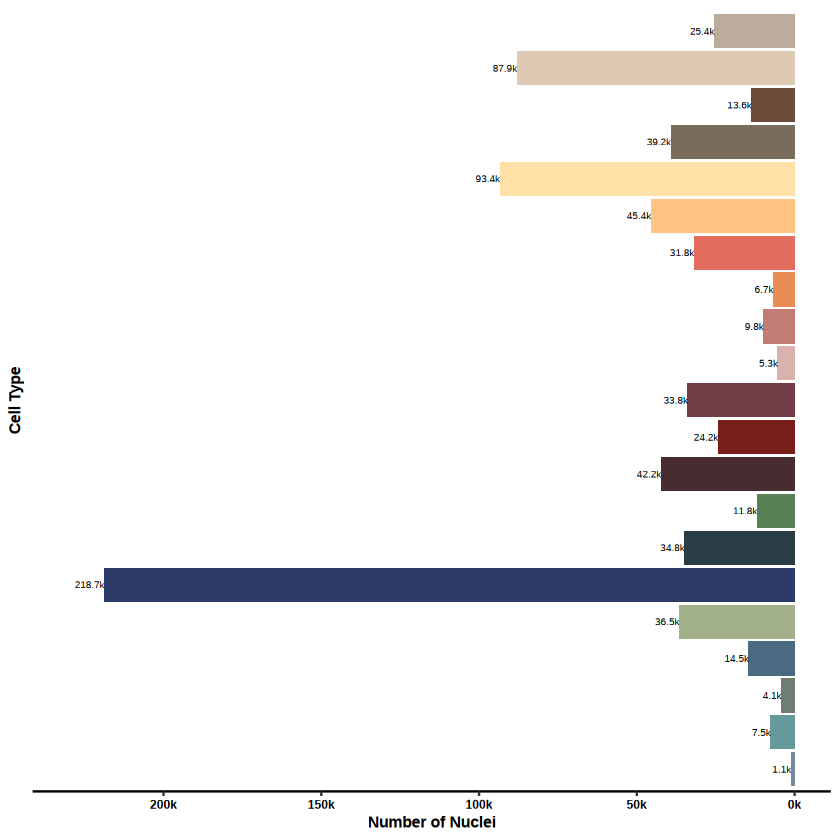

In [16]:
library(ggplot2)
ggplot(data=n_nuclei_per_celltype, aes(x=celltype, y = n_nuclei/1000,  fill = celltype)) + 
  geom_bar(stat="identity", show.legend = FALSE) +
  labs(y = "Number of Nuclei", x = 'Cell Type') + coord_flip() +
  theme_classic() + geom_text(aes(x= celltype, label = n_nuclei_per_celltype$label, hjust = 1), size=2,  colour = "black") + 
theme(axis.text=element_text(size=7, face='bold', color='black'), axis.title=element_text(size=9,face="bold"), 
      axis.line.y=element_blank(),axis.text.y=element_blank(), axis.ticks.y=element_blank()) + scale_fill_manual(values =(n_nuclei_per_celltype$color)) +
scale_y_reverse(breaks = c(0, 50, 100, 150, 200), label = c("0k", "50k", "100k", '150k', '200k'), limits=c(230,0))

#ggsave('../figures/barplot_total_n_nuclei_per_celltype.pdf', plot=last_plot(), width=3.5, height=4)

# Process data: log2 CPM + voom precision weights

## Normalization

In [17]:
# turn warnings back on
options(warn=0)

In [18]:
form <- ~ (1|X6.Batch) + (1|Sex) + (1|Disease_Status) + Age + PMI + RIN + Brain.pH + PC1

res.proc <- processAssays(pb, form, min.count=10, min.prop=0.8, 
                                     min.cells=5, min.samples=61,BPPARAM = SnowParam(12))

  Exc_L2-3...
5.4 mins

  Exc_L3-5...
4.5 mins

  Exc_L4-6_1...
5 mins

  Exc_L4-6_2...
4.9 mins

  Exc_L4-6_3...
4.6 mins

  Exc_L5-6_1...
4.1 mins

  Exc_L5-6_2...
4.2 mins

  Exc_L5-6_HTR2C...
4.1 mins

  In_LAMP5_1...
4.3 mins

  In_LAMP5_2...
4.3 mins

  In_PVALB_Ba...
4.8 mins

  In_PVALB_Ch...
4.2 mins

  In_RELN...
4.7 mins

  In_SST...
4.7 mins

  In_VIP...
4.9 mins

  Astro_FB...
4.2 mins

  Astro_PP...
4.6 mins

  Endothelial...
4.3 mins

  Microglia...
4.3 mins

  Oligodendrocyte...
4.6 mins

  OPC...
4.6 mins


Of 180,732 models fit across all assays, 0.00221% failed




In [19]:
# view details of dropping samples
details(res.proc)

assay,n_retain,formula,formDropsTerms,n_genes,n_errors,error_initial
<chr>,<int>,<chr>,<lgl>,<int>,<int>,<lgl>
Exc_L2-3,87,~(1 | X6.Batch) + (1 | Sex) + (1 | Disease_Status) + Age + PMI + RIN + Brain.pH + PC1,FALSE,18064,0,FALSE
Exc_L3-5,87,~(1 | X6.Batch) + (1 | Sex) + (1 | Disease_Status) + Age + PMI + RIN + Brain.pH + PC1,FALSE,8809,0,FALSE
Exc_L4-6_1,87,~(1 | X6.Batch) + (1 | Sex) + (1 | Disease_Status) + Age + PMI + RIN + Brain.pH + PC1,FALSE,12977,0,FALSE
Exc_L4-6_2,87,~(1 | X6.Batch) + (1 | Sex) + (1 | Disease_Status) + Age + PMI + RIN + Brain.pH + PC1,FALSE,12375,0,FALSE
Exc_L4-6_3,84,~(1 | X6.Batch) + (1 | Sex) + (1 | Disease_Status) + Age + PMI + RIN + Brain.pH + PC1,FALSE,9934,0,FALSE
Exc_L5-6_1,80,~(1 | X6.Batch) + (1 | Sex) + (1 | Disease_Status) + Age + PMI + RIN + Brain.pH + PC1,FALSE,6652,4,FALSE
Exc_L5-6_2,70,~(1 | X6.Batch) + (1 | Sex) + (1 | Disease_Status) + Age + PMI + RIN + Brain.pH + PC1,FALSE,1922,0,FALSE
Exc_L5-6_HTR2C,85,~(1 | X6.Batch) + (1 | Sex) + (1 | Disease_Status) + Age + PMI + RIN + Brain.pH + PC1,FALSE,4634,0,FALSE
In_LAMP5_1,87,~(1 | X6.Batch) + (1 | Sex) + (1 | Disease_Status) + Age + PMI + RIN + Brain.pH + PC1,FALSE,7497,0,FALSE


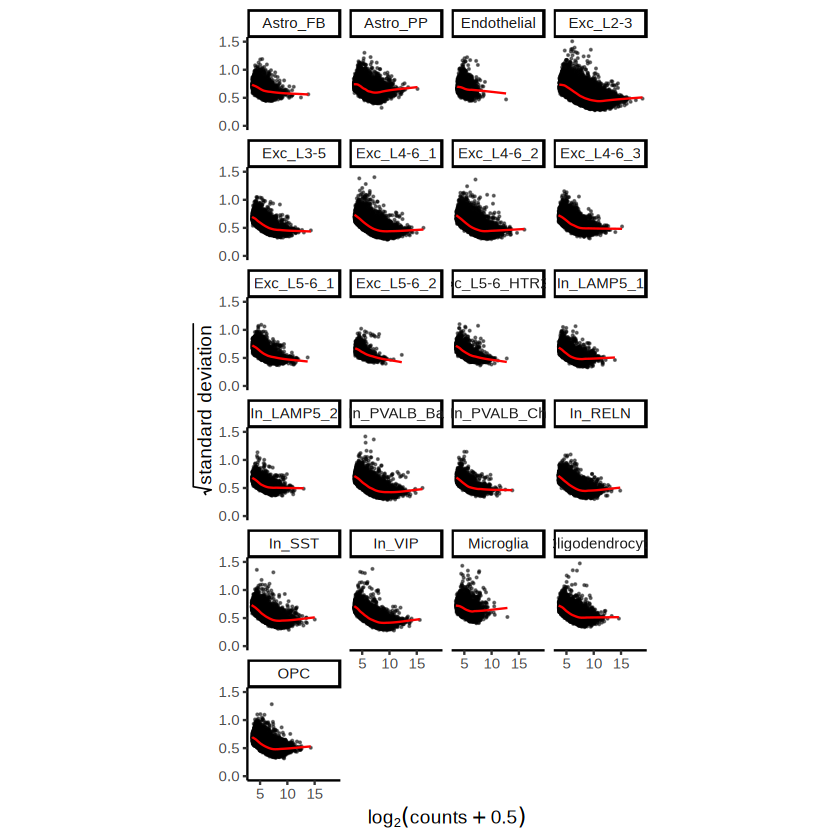

In [20]:
### Show voom-style mean-variance trends
# show voom plot for each cell clusters  
plotVoom(res.proc,assays=ctorder, ncol=4)

In [21]:
#pdf(file = "../figures/dreamlet_Voom_20231121.pdf", width = 6, height = 6)

#plotVoom(res.proc,assays=ctorder, ncol=4) + theme_classic()
#dev.off()

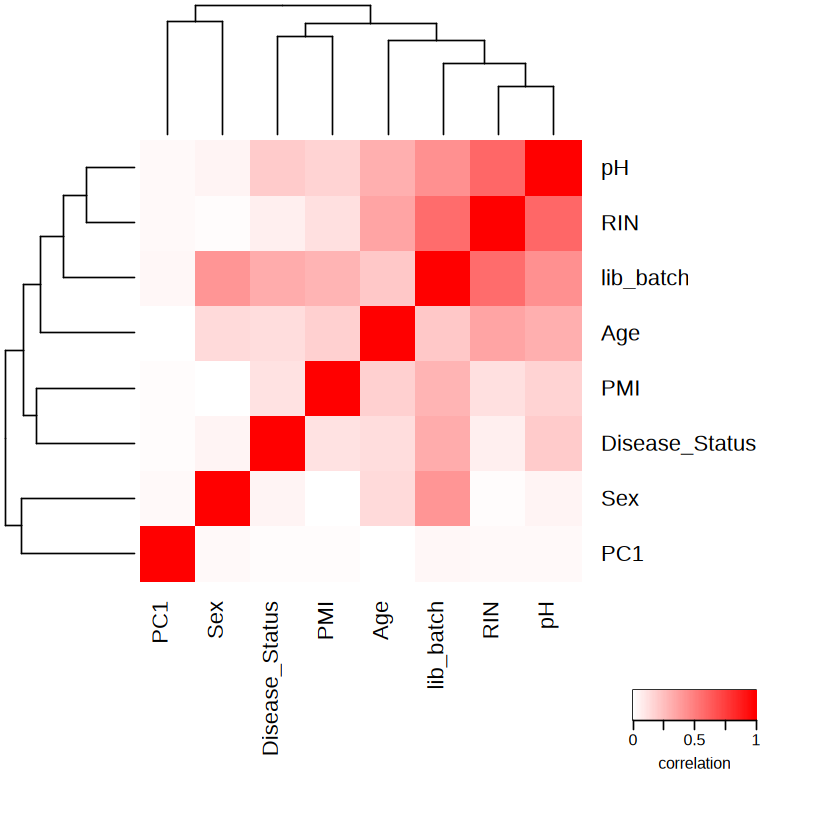

In [22]:
## Relationship between variables
#Use canonical correlation analysis to show association between variables
form <-  ~ X6.Batch + Sex + Age + Disease_Status + PMI + RIN + Brain.pH + PC1

C <- canCorPairs(form, colData(res.proc))
row.names(C)[1] <- "lib_batch"
row.names(C)[7] <- "pH"
colnames(C)[1] <- "lib_batch"
colnames(C)[7] <- "pH"

plotCorrMatrix(C)

In [23]:
#pdf(file = "../figures/dreamlet_ConCa_20231121.pdf")

#plotCorrMatrix(C)
#dev.off()

# Variance partitioning

In [24]:
# run variance partitioning analysis
form <- ~ (1|X6.Batch) + (1|Sex) + (1|Disease_Status) + Age + PMI + RIN + Brain.pH + PC1
res.vp <- fitVarPart(res.proc, form, BPPARAM = SnowParam(12))

  Exc_L2-3...
1.8 mins

  Exc_L3-5...
1.2 mins

  Exc_L4-6_1...
1.5 mins

  Exc_L4-6_2...
1.5 mins

  Exc_L4-6_3...
1.5 mins

  Exc_L5-6_1...
1.2 mins

  Exc_L5-6_2...
52 secs

  Exc_L5-6_HTR2C...
1 mins

  In_LAMP5_1...
1.1 mins

  In_LAMP5_2...
1 mins

  In_PVALB_Ba...
1.4 mins

  In_PVALB_Ch...
1 mins

  In_RELN...
1.4 mins

  In_SST...
1.3 mins

  In_VIP...
1.4 mins

  Astro_FB...
1 mins

  Astro_PP...
1.3 mins

  Endothelial...
55 secs

  Microglia...
1 mins

  Oligodendrocyte...
1.2 mins

  OPC...
1.2 mins






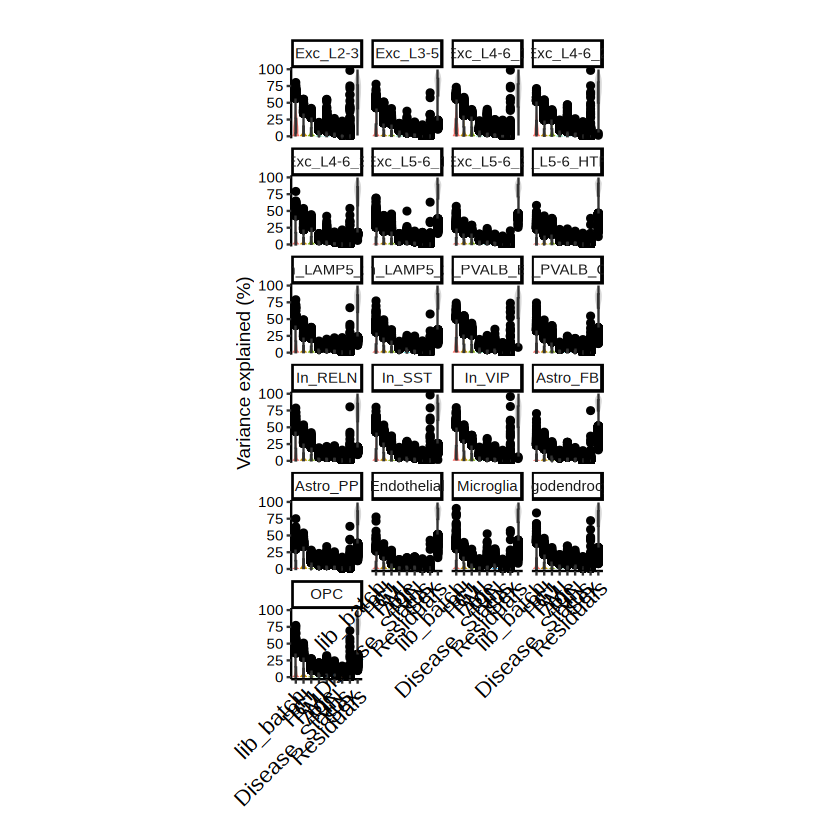

In [25]:
#colnames(res.vp)
colnames(res.vp)[colnames(res.vp) == "X6.Batch"] <- 'lib_batch'
colnames(res.vp)[colnames(res.vp) == "Brain.pH"] <- 'pH'
 
plotVarPart( sortCols(res.vp), label.angle=45, ncol=4 )

In [26]:
#pdf(file = "../figures/dreamlet_Variance_P_20231121.pdf", width = 12, height = 14) 

#plotVarPart(sortCols(res.vp), label.angle=45, ncol=4, col=c("#f9c29b","#fc8814", "#4f7eae","#172d44", "#1a2e18", "#508c49", "#4f3a52","#652d05",  "#500050"))
#dev.off()

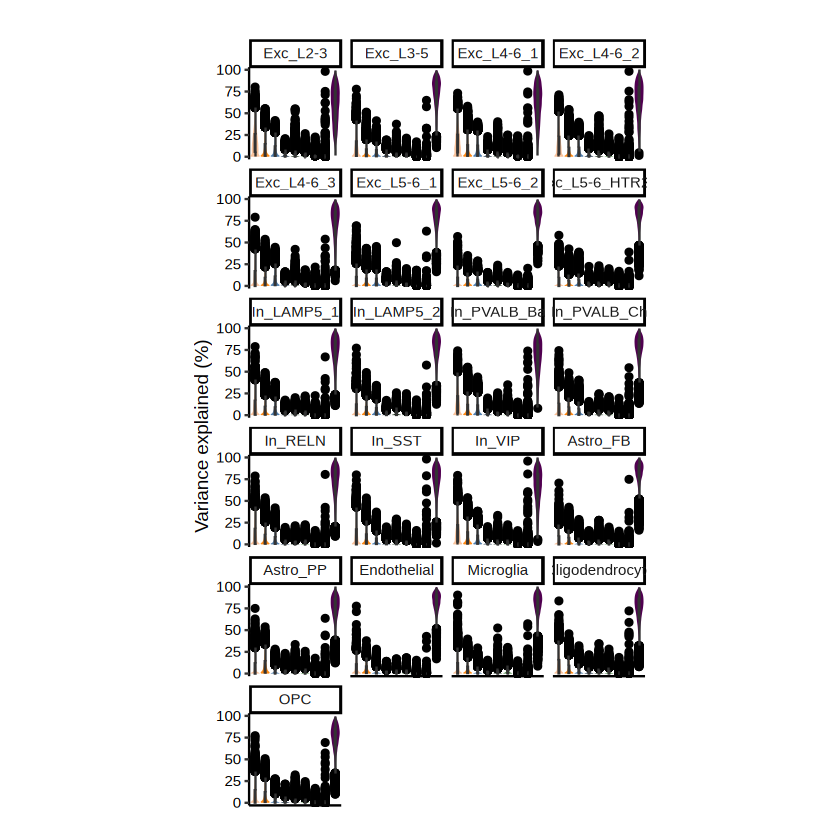

In [27]:
#pdf(file = "../figures/dreamlet_Variance_P_wo_x-axis_labels_20231121.pdf", width = 12, height = 14) 

plotVarPart(sortCols(res.vp), label.angle=45, ncol=4, col=c("#f9c29b","#fc8814", "#4f7eae","#172d44",
                                                                      "#1a2e18", "#508c49", "#4f3a52","#652d05", 
                                                                      "#500050")) +
  theme(axis.text.x=element_blank(), #remove x axis labels
        axis.ticks.x=element_blank())
#dev.off()

## Ext. Data Fig. 4c

In [42]:
vp_results_table <- as.data.frame(matrix(ncol=10, nrow=length(res.vp@listData$assay)))
colnames(vp_results_table) <- c('celltype', 'lib_batch', 'pH', 'PC1', 'PMI', 'Age', 'RIN', 'Disease_Status', 'Sex', 'Residuals')

In [44]:
vp_results_table$celltype <- res.vp@listData$assay
vp_results_table$lib_batch <- res.vp@listData$lib_batch
vp_results_table$pH <- res.vp@listData$pH
vp_results_table$PC1 <- res.vp@listData$PC1
vp_results_table$PMI <- res.vp@listData$PMI
vp_results_table$Age <- res.vp@listData$Age
vp_results_table$RIN <- res.vp@listData$RIN
vp_results_table$Disease_Status <- res.vp@listData$Disease_Status
vp_results_table$Sex <- res.vp@listData$Sex
vp_results_table$Residuals <- res.vp@listData$Residuals

In [45]:
head(vp_results_table)

,celltype,lib_batch,pH,PC1,PMI,Age,RIN,Disease_Status,Sex,Residuals
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Exc_L2-3,0.04991103,0.02777044,0.015798874,0.034060894,0.0526797306,1.146514e-10,0.000000e+00,7.396321e-14,0.8197790
2,Exc_L2-3,0.02784367,0.03382853,0.058216766,0.019030714,0.0024893235,2.271360e-02,0.000000e+00,0.000000e+00,0.8358774
3,Exc_L2-3,0.16688577,0.22419925,0.034616935,0.011583860,0.0034471350,6.224119e-05,0.000000e+00,0.000000e+00,0.5592048
4,Exc_L2-3,0.22239678,0.00257494,0.031896934,0.001591431,0.0001439501,2.100306e-02,0.000000e+00,0.000000e+00,0.7203929
5,Exc_L2-3,0.21949186,0.24889958,0.084502192,0.011005591,0.0101528075,6.653151e-02,4.639154e-16,9.505161e-03,0.3499113
6,Exc_L2-3,0.16026184,0.06305620,0.009214577,0.003276471,0.0004063768,2.141827e-03,0.000000e+00,9.643889e-20,0.7616427


In [47]:
df_vp_results_summarized <- vp_results_table %>%
as_tibble %>% 
group_by(celltype) %>% 
    summarise( 
      mean_lib_batch = (median(lib_batch)*100), 
      mean_pH = (median(pH)*100),
        median_PC1= (median(PC1)*100),
        median_PMI = (median(PMI)*100),
        median_Age = (median(Age)*100),
        median_RIN = (median(RIN)*100),
        median_Disease_Status = (median(Disease_Status)*100),
        median_Sex = (median(Sex)*100),
        median_Residuals = (median(Residuals)*100))      
df_vp_results_summarized

celltype,mean_lib_batch,mean_pH,median_PC1,median_PMI,median_Age,median_RIN,median_Disease_Status,median_Sex,median_Residuals
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Exc_L2-3,14.740613,5.518744,4.9292220,1.4719728,1.0610860,0.7787453,0,0.000000e+00,60.67708
Exc_L3-5,8.083117,2.942609,2.8095109,1.2668386,0.7541765,0.7452854,0,0.000000e+00,75.45660
Exc_L4-6_1,13.681844,5.027247,5.3748917,1.3725013,0.8278914,0.6955289,0,0.000000e+00,62.86040
Exc_L4-6_2,11.888567,3.752977,4.1840636,1.5260459,0.9546961,0.9925136,0,0.000000e+00,66.88684
Exc_L4-6_3,7.018631,3.376058,4.3115792,0.9268252,0.8157261,0.5542377,0,0.000000e+00,74.58293
Exc_L5-6_1,2.522839,3.012260,3.1524491,0.7954044,0.8382144,0.6065087,0,8.129493e-09,80.40303
Exc_L5-6_2,1.709060,2.608325,2.8410017,0.8450764,0.9722200,0.6642905,0,0.000000e+00,81.56297
Exc_L5-6_HTR2C,1.742480,1.992735,2.2706570,0.7267975,0.6796729,0.7919741,0,0.000000e+00,83.19178
In_LAMP5_1,7.532054,3.524577,3.5277845,0.8662632,0.9074155,0.7689055,0,0.000000e+00,74.98988


In [48]:
# get median variance explained by Age per cell type to specify order
median_V_E_Age <- vp_results_table %>%
  group_by(celltype) %>%
  dplyr::summarize(Median = median(Age, na.rm=TRUE))

median_V_E_Age <- as.data.frame(median_V_E_Age)
median_V_E_Age <- median_V_E_Age[order(-median_V_E_Age$Median),]
median_V_E_Age$celltype
vp_results_table$celltype <- factor(vp_results_table$celltype, levels=median_V_E_Age$celltype)


[1] In_LAMP5_2      Exc_L2-3        In_PVALB_Ch     Exc_L5-6_2     
 [5] Exc_L4-6_2      In_SST          In_LAMP5_1      Oligodendrocyte
 [9] In_VIP          Exc_L5-6_1      Exc_L4-6_1      Exc_L4-6_3     
[13] Astro_FB        In_RELN         Exc_L3-5        Microglia      
[17] OPC             Astro_PP        In_PVALB_Ba     Endothelial    
[21] Exc_L5-6_HTR2C 
21 Levels: Exc_L2-3 Exc_L3-5 Exc_L4-6_1 Exc_L4-6_2 Exc_L4-6_3 ... OPC

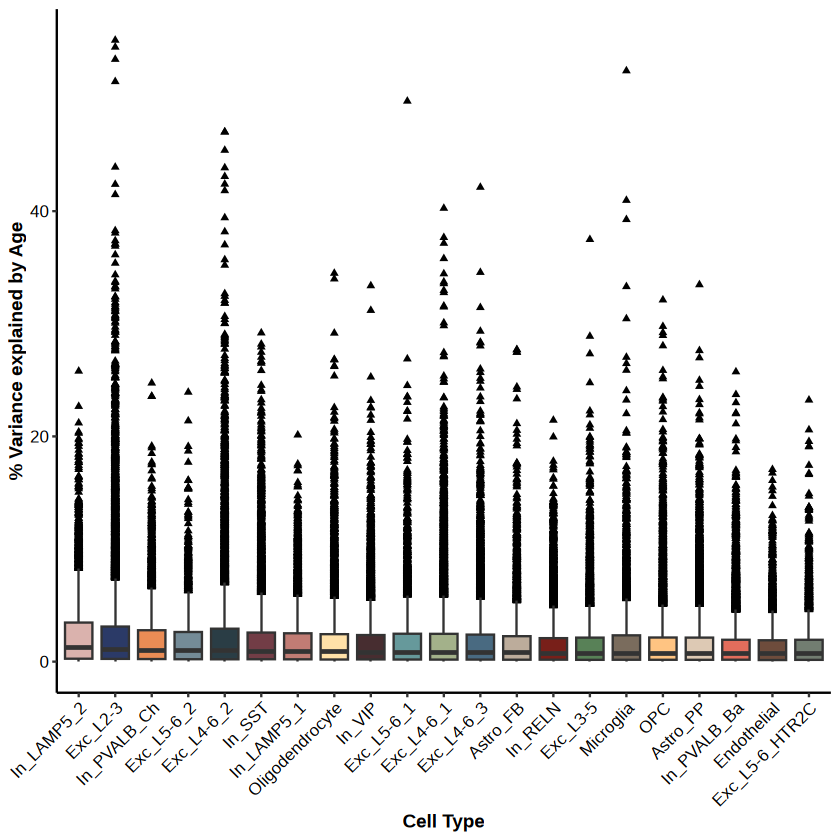

In [61]:
# Variance explained in % thus *100
ggplot(vp_results_table, aes(x=celltype, y=Age*100, fill=celltype)) + 
  geom_boxplot(outlier.color="black", outlier.shape=17) + #geom_jitter(shape=16, colour='black', position=position_jitter(0.2)) +
theme_classic() + theme(legend.position = 'none')+ ylab('% Variance explained by Age') + xlab('Cell Type') +
  theme(axis.text.x = element_text(angle = 45, vjust=1, hjust=1, color='black', size=10), 
        axis.text.y = element_text(color='black',size=10), axis.title.y = element_text(face='bold', size=11), 
        axis.title.x=element_text(face='bold', size=11)) +
scale_fill_manual(values=c('#dab2ad','#2B3A67','#EA8C55','#748b97', '#2A3D45', '#723D46', '#C17C74', '#FFE1A8', '#472D30',
                          '#66999B', '#A3B18A', '#496A81', '#BCAC9B', '#781F19','#588157', '#7A6C5D', '#FFC482', '#DDC9B4',
                          '#E26D5C', '#6e4c3c', '#727D71'))

In [62]:
ggsave('../figures/boxplot_variance_explained_age_wo_jitter.pdf', plot = last_plot(), height =5 , width =5)

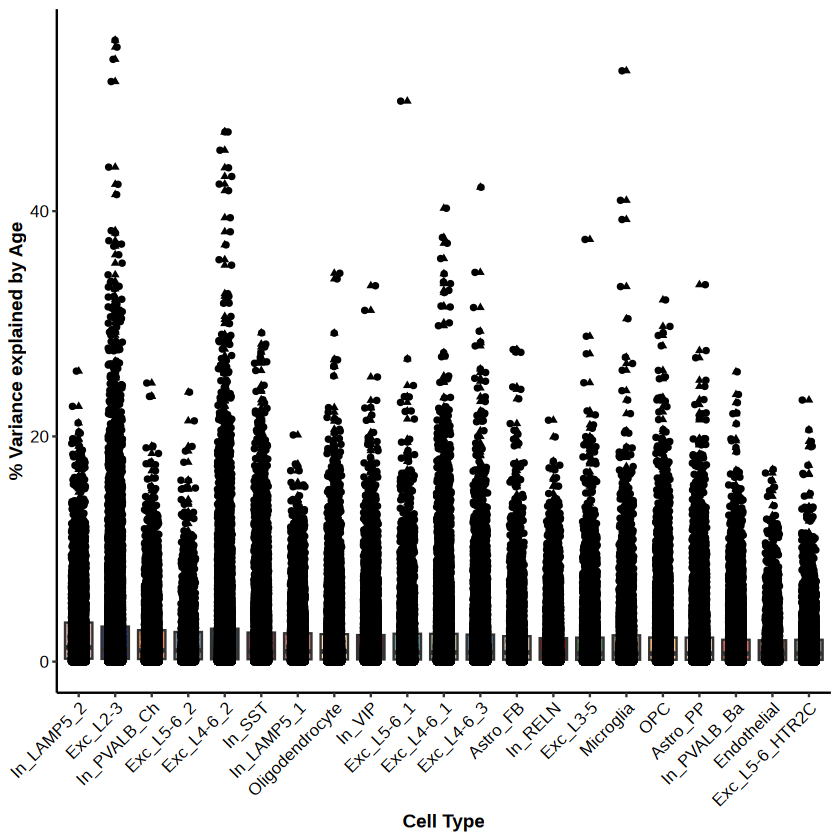

In [63]:
ggplot(vp_results_table, aes(x=celltype, y=Age*100, fill=celltype)) + 
  geom_boxplot(outlier.color="black", outlier.shape=17) + geom_jitter(shape=16, colour='black', position=position_jitter(0.2)) +
theme_classic() + theme(legend.position = 'none')+ ylab('% Variance explained by Age') + xlab('Cell Type') +
  theme(axis.text.x = element_text(angle = 45, vjust=1, hjust=1, color='black', size=10), 
        axis.text.y = element_text(color='black',size=10), axis.title.y = element_text(face='bold', size=11), 
        axis.title.x=element_text(face='bold', size=11)) +
scale_fill_manual(values=c('#dab2ad','#2B3A67','#EA8C55','#748b97', '#2A3D45', '#723D46', '#C17C74', '#FFE1A8', '#472D30',
                          '#66999B', '#A3B18A', '#496A81', '#BCAC9B', '#781F19','#588157', '#7A6C5D', '#FFC482', '#DDC9B4',
                          '#E26D5C', '#6e4c3c', '#727D71'))

In [64]:
ggsave('../figures/boxplot_variance_explained_age_with_jitter.pdf', plot = last_plot(), height =5 , width =5)

In [50]:
library(rstatix)
stat.test <- vp_results_table %>%
  wilcox_test(Age ~ celltype) %>%
# adjust p-val using fdr (BH)
  adjust_pvalue(method = "BH") %>%
  add_significance()

In [65]:
stat.test$p.adj[1:10]

[1] 1.251000e-03 7.837113e-08 1.271053e-05 1.927917e-10 5.476471e-17
 [6] 1.577692e-21 3.576000e-24 3.001765e-34 5.803636e-26 5.166000e-30

# Differential Gene Expression Analysis

## Age

In [24]:
# ~ 2h 45 min
form <- ~ (1|X6.Batch) + (1|Sex) + (1|Disease_Status) + Age + PMI + RIN + Brain.pH + PC1

fit <- dreamlet(res.proc, form, BPPARAM = SnowParam(12))

  Exc_L2-3...
17 mins

  Exc_L3-5...
8.6 mins

  Exc_L4-6_1...
12 mins

  Exc_L4-6_2...
12 mins

  Exc_L4-6_3...
9.5 mins

  Exc_L5-6_1...
6.7 mins

  Exc_L5-6_2...
2.5 mins

  Exc_L5-6_HTR2C...
5.1 mins

  In_LAMP5_1...
7.5 mins

  In_LAMP5_2...
5.6 mins

  In_PVALB_Ba...
11 mins

  In_PVALB_Ch...
5.4 mins

  In_RELN...
10 mins

  In_SST...
10 mins

  In_VIP...
12 mins

  Astro_FB...
5.4 mins

  Astro_PP...
10 mins

  Endothelial...
3 mins

  Microglia...
5.6 mins

  Oligodendrocyte...
8.7 mins

  OPC...
9.2 mins


Of 180,732 models fit across all assays, 0.626% failed




In [25]:
df_de_Age <- fit %>%
  topTable(coef='Age', number=Inf) %>%
    as_tibble %>% 
    group_by(assay) %>% 
    summarise( 
      nGenes_tested = length(adj.P.Val), 
      nDE_0.1 = sum(adj.P.Val < 0.1),
        nDE_0.05 = sum(adj.P.Val < 0.05),
      pi1 = 1 - qvalue(P.Value)$pi0) %>%
mutate(assay = factor(assay))  
df_de_Age

assay,nGenes_tested,nDE_0.1,nDE_0.05,pi1
<fct>,<int>,<int>,<int>,<dbl>
Astro_FB,5017,183,97,0.1521465
Astro_PP,10391,348,168,0.2279359
Endothelial,2714,78,26,0.2025991
Exc_L2-3,17910,1925,1189,0.4307607
Exc_L3-5,8759,323,161,0.1823488
Exc_L4-6_1,12872,955,584,0.3511773
Exc_L4-6_2,12284,1156,731,0.3343823
Exc_L4-6_3,9866,469,244,0.2520815
Exc_L5-6_1,6618,212,110,0.2292242


In [26]:
DE_results_Age <- fit %>%
  topTable(coef='Age', number=Inf) %>%
    as_tibble %>% 
    group_by(assay)

DE_results_Age <- as.data.frame(DE_results_Age)

In [27]:
# structure DE results in a list of dataframes
# each dataframe represents a cell type
DE_res_Age_list <- list()
for (celltype in assayNames(pb)){
    DE_res_Age_list[[celltype]] <- DE_results_Age[DE_results_Age$assay==celltype,] 
}

library(writexl)
write_xlsx(DE_res_Age_list, path = "../results/dreamlet_tables/final_celltypes_N87/DE_results_Age_20231121.xlsx", col_names = TRUE)

## Supplementary Table 5 & 6

In [2]:
library(readxl)
celltypes <- c('Exc_L2-3','Exc_L3-5','Exc_L4-6_1','Exc_L4-6_2','Exc_L4-6_3','Exc_L5-6_1','Exc_L5-6_2','Exc_L5-6_HTR2C',
               'In_LAMP5_1','In_LAMP5_2','In_PVALB_Ba','In_PVALB_Ch','In_RELN','In_SST','In_VIP','Astro_FB','Astro_PP',
               'Endothelial','Microglia','Oligodendrocyte','OPC')

# Age
DE_Age_results <- list()
for (celltype in celltypes){
  DE_Age_results[[celltype]] <- as.data.frame(read_excel('../results/dreamlet_tables/final_celltypes_N87/DE_results_Age_20231121.xlsx', sheet = celltype))
}

# row bind individual dataframes to one dataframe
library(dplyr)
DE_Age <- bind_rows(DE_Age_results)

In [3]:
# read in the gene information from adata object to obtain gene name (ID) and ensembl ID
var <- read.delim("../datasets/adata.var_20231120.tsv", sep='\t')

#select gene ID and ensembl ID
gene_names_ensembl <- var %>% select('X', 'gene_ids')
gene_names_ensembl <- as.data.frame(gene_names_ensembl)
colnames(gene_names_ensembl) <- c('ID', 'ensembl')
head(gene_names_ensembl)

,ID,ensembl
,<chr>,<chr>
1,AL627309.1,ENSG00000238009
2,AL627309.5,ENSG00000241860
3,LINC01409,ENSG00000237491
4,LINC01128,ENSG00000228794
5,LINC00115,ENSG00000225880
6,FAM41C,ENSG00000230368


In [4]:
DE_Age_final <- merge(DE_Age, gene_names_ensembl, by='ID')
DE_Age_final <- DE_Age_final %>% select(c('assay','ID', 'ensembl', 'logFC','AveExpr','t','P.Value','adj.P.Val','B','z.std' ))
head(DE_Age_final)

library(writexl)
#write_xlsx(DE_Age_final, path = "../results/dreamlet_tables/final_celltypes_N87/DE_results_Age_w_ensembl_20231121.xlsx", col_names = TRUE)

,assay,ID,ensembl,logFC,AveExpr,t,P.Value,adj.P.Val,B,z.std
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Exc_L2-3,A1BG,ENSG00000121410,-0.0090387917,2.638112,-3.3014958,0.001493969,0.04887402,-3.113740,-3.1758524
2,Exc_L4-6_1,A1BG,ENSG00000121410,-0.0020956779,2.358308,-0.5276173,0.599087600,0.84962883,-7.774859,-0.5257130
3,Exc_L4-6_2,A1BG,ENSG00000121410,-0.0032115962,2.571500,-0.7782006,0.438800311,0.75956065,-7.596725,-0.7742207
4,Exc_L4-6_1,A1BG-AS1,ENSG00000268895,0.0018766647,2.841536,0.5575790,0.578700812,0.83955539,-7.840444,0.5552834
5,Exc_L4-6_2,A1BG-AS1,ENSG00000268895,-0.0029292402,2.855724,-0.7774795,0.438951104,0.75964510,-7.637216,-0.7739657
6,Exc_L2-3,A1BG-AS1,ENSG00000268895,-0.0007041084,3.320240,-0.2536511,0.800439513,0.93515649,-8.359883,-0.2527783


In [5]:
df_de_Age <- DE_Age_final %>%
    as_tibble %>% 
    group_by(assay) %>% 
    summarise( 
      nGenes_tested = length(adj.P.Val), 
      nDE_0.1 = sum(adj.P.Val < 0.1),
        nDE_0.05 = sum(adj.P.Val < 0.05)) %>%
mutate(assay = factor(assay))  
df_de_Age <- as.data.frame(df_de_Age)
df_de_Age

#write_xlsx(df_de_Age, path = "../results/dreamlet_tables/final_celltypes_N87/n_DEgenes_Age_final_celltypes.xlsx", col_names = TRUE)

assay,nGenes_tested,nDE_0.1,nDE_0.05
<fct>,<int>,<int>,<int>
Astro_FB,5017,183,97
Astro_PP,10391,348,168
Endothelial,2714,78,26
Exc_L2-3,17910,1925,1189
Exc_L3-5,8759,323,161
Exc_L4-6_1,12872,955,584
Exc_L4-6_2,12284,1156,731
Exc_L4-6_3,9866,469,244
Exc_L5-6_1,6618,212,110


In [6]:
# Number of genes DE across all 21 cell types
DE_res_Age_list <- list()
for (celltype in unique(DE_Age_final$assay)){
    tmp <- DE_Age_final[DE_Age_final$assay==celltype,] 
    DE_res_Age_list[[celltype]] <- tmp[tmp$adj.P.Val < 0.05,]
}

Reduce(intersect, list(DE_res_Age_list[["Exc_L2-3"]]$ID, DE_res_Age_list[["Exc_L4-6_1"]]$ID,
                       DE_res_Age_list[["Exc_L4-6_2"]]$ID, DE_res_Age_list[["In_VIP"]]$ID,
                       DE_res_Age_list[["Exc_L4-6_3"]]$ID, DE_res_Age_list[["In_RELN"]]$ID, 
                       DE_res_Age_list[["Microglia"]]$ID, DE_res_Age_list[["Endothelial"]]$ID, 
                       DE_res_Age_list[["Astro_PP"]]$ID, DE_res_Age_list[["In_PVALB_Ba"]]$ID, 
                       DE_res_Age_list[["Oligodendrocyte"]]$ID, DE_res_Age_list[["In_SST"]]$ID,
                       DE_res_Age_list[["OPC"]]$ID, DE_res_Age_list[["Exc_L5-6_1"]]$ID, 
                       DE_res_Age_list[["In_LAMP5_2"]]$ID, DE_res_Age_list[["Exc_L3-5"]]$ID,
                       DE_res_Age_list[["In_PVALB_Ch"]]$ID, DE_res_Age_list[["Exc_L5-6_2"]]$ID,
                       DE_res_Age_list[["Exc_L5-6_HTR2C"]]$ID, DE_res_Age_list[["In_LAMP5_1"]]$ID,
                       DE_res_Age_list[["Astro_FB"]]$ID))

# 0 shared genes across all 21 cell types

character(0)

## Disease Status

In [28]:
# ~ 2h 45 min
form_2 <- ~ (1|X6.Batch) + (1|Sex) + Disease_Status + Age + PMI + RIN + Brain.pH + PC1

fit_2 <- dreamlet(res.proc, form_2, BPPARAM = SnowParam(12))

  Exc_L2-3...
16 mins

  Exc_L3-5...
8.3 mins

  Exc_L4-6_1...
12 mins

  Exc_L4-6_2...
11 mins

  Exc_L4-6_3...
9.2 mins

  Exc_L5-6_1...
6.5 mins

  Exc_L5-6_2...
2.6 mins

  Exc_L5-6_HTR2C...
4.7 mins

  In_LAMP5_1...
7.2 mins

  In_LAMP5_2...
5.4 mins

  In_PVALB_Ba...
11 mins

  In_PVALB_Ch...
5.3 mins

  In_RELN...
9.7 mins

  In_SST...
9.8 mins

  In_VIP...
11 mins

  Astro_FB...
5.3 mins

  Astro_PP...
9.6 mins

  Endothelial...
2.9 mins

  Microglia...
5.4 mins

  Oligodendrocyte...
8.4 mins

  OPC...
8.9 mins


Of 180,732 models fit across all assays, 0.115% failed




In [30]:
df_de_Disease <- fit_2 %>%
  topTable(coef='Disease_StatusCases', number=Inf) %>%
    as_tibble %>% 
    group_by(assay) %>% 
    summarise( 
      nGenes_tested = length(adj.P.Val), 
      nDE_0.1 = sum(adj.P.Val < 0.1),
        nDE_0.05 = sum(adj.P.Val < 0.05)) %>%
mutate(assay = factor(assay))  
df_de_Disease

assay,nGenes_tested,nDE_0.1,nDE_0.05
<fct>,<int>,<int>,<int>
Astro_FB,5035,0,0
Astro_PP,10434,0,0
Endothelial,2716,0,0
Exc_L2-3,18044,7,2
Exc_L3-5,8799,0,0
Exc_L4-6_1,12959,10,6
Exc_L4-6_2,12356,3,0
Exc_L4-6_3,9923,1,0
Exc_L5-6_1,6647,0,0


In [31]:
DE_results_Disease <- fit_2 %>%
  topTable(coef='Disease_StatusCases', number=Inf) %>%
    as_tibble %>% 
    group_by(assay)

DE_results_Disease <- as.data.frame(DE_results_Disease)

In [32]:
# structure DE results in a list of dataframes
# each dataframe represents a cell type
DE_res_Disease_list <- list()
for (celltype in assayNames(pb)){
    DE_res_Disease_list[[celltype]] <- DE_results_Disease[DE_results_Disease$assay==celltype,] 
}

#write_xlsx(DE_res_Disease_list, path = "../results/dreamlet_tables/final_celltypes_N87/DE_results_Disease_20231121.xlsx", col_names = TRUE)

## Supplementary Table 12

In [2]:
library(readxl)
celltypes <- c('Exc_L2-3','Exc_L3-5','Exc_L4-6_1','Exc_L4-6_2','Exc_L4-6_3','Exc_L5-6_1','Exc_L5-6_2','Exc_L5-6_HTR2C',
               'In_LAMP5_1','In_LAMP5_2','In_PVALB_Ba','In_PVALB_Ch','In_RELN','In_SST','In_VIP','Astro_FB','Astro_PP',
               'Endothelial','Microglia','Oligodendrocyte','OPC')

# Disease Status
DE_Disease_results <- list()
for (celltype in celltypes){
  DE_Disease_results[[celltype]] <- as.data.frame(read_excel('../results/dreamlet_tables/final_celltypes_N87/DE_results_Disease_20231121.xlsx', sheet = celltype))
}

# read in the gene information from adata object to obtain gene name (ID) and ensembl ID
var <- read.delim("../datasets/adata.var_20231120.tsv", sep='\t')

#select gene ID and ensembl ID
gene_names_ensembl <- var %>% select('X', 'gene_ids')
gene_names_ensembl <- as.data.frame(gene_names_ensembl)
colnames(gene_names_ensembl) <- c('ID', 'ensembl')

# perform multiple testing correction only within each cell type (not across all tested genes of all cell types)
# add ensembl ID to all genes
DE_res_Disease_list_within_celltype_corr <- list()
for (celltype in names(DE_Disease_results)){
    tmp <- DE_Disease_results[[celltype]]
    tmp$p.adj_within_celltype <- p.adjust(tmp$P.Value, method='fdr', n=length(tmp$P.Value))
    tmp <- merge(tmp, gene_names_ensembl, by='ID')
    tmp <- tmp %>% select(c('assay','ID', 'ensembl', 'logFC','AveExpr','t','P.Value','adj.P.Val','p.adj_within_celltype','B','z.std' ))
    DE_res_Disease_list_within_celltype_corr[[celltype]] <- tmp
}


# row bind individual dataframes to one dataframe
library(dplyr)
DE_Disease_Status <- bind_rows(DE_res_Disease_list_within_celltype_corr)
head(DE_Disease_Status)

,assay,ID,ensembl,logFC,AveExpr,t,P.Value,adj.P.Val,p.adj_within_celltype,B,z.std
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Exc_L2-3,A1BG,ENSG00000121410,0.05486157,2.6381125,0.7168751,0.47590598,0.9408609,0.8417277,-5.521966,0.7129027
2,Exc_L2-3,A1BG-AS1,ENSG00000268895,-0.08684037,3.3202398,-1.1572596,0.25040352,0.8804949,0.7024925,-5.294050,-1.1493698
3,Exc_L2-3,A2M,ENSG00000175899,0.20097070,1.7659902,1.9251941,0.05802966,0.7375490,0.4726197,-4.021736,1.8954738
4,Exc_L2-3,A2M-AS1,ENSG00000245105,-0.10627374,1.1288649,-1.0536020,0.29508138,0.8955744,0.7379111,-5.034876,-1.0470395
5,Exc_L2-3,A2ML1,ENSG00000166535,0.12110789,0.9161682,1.3482469,0.18177648,0.8509087,0.6495160,-4.710728,1.3353052
6,Exc_L2-3,A2ML1-AS1,ENSG00000256661,-0.03941252,2.9957470,-0.6920401,0.49094547,0.9433822,0.8490769,-5.625367,-0.6888058


In [3]:
library(writexl)
write_xlsx(DE_Disease_Status, path = "../results/dreamlet_tables/final_celltypes_N87/DE_results_Disease_w_ensembl_20231121.xlsx", col_names = TRUE)

In [4]:
df_de_Disease <- DE_Disease_Status %>%
    as_tibble %>% 
    group_by(assay) %>% 
    summarise( 
      nGenes_tested = length(adj.P.Val), 
      nDE_0.1 = sum(adj.P.Val < 0.1),
        nDE_0.05 = sum(adj.P.Val < 0.05),
        nDE_0.05_within_celltype = sum(p.adj_within_celltype < 0.05),
        nDE_0.1_within_celltype = sum(p.adj_within_celltype < 0.1)) %>%
        mutate(assay = factor(assay))  
df_de_Disease[c(4,6,7,8),]

assay,nGenes_tested,nDE_0.1,nDE_0.05,nDE_0.05_within_celltype,nDE_0.1_within_celltype
<fct>,<int>,<int>,<int>,<int>,<int>
Exc_L2-3,18044,7,2,27,67
Exc_L4-6_1,12959,10,6,50,108
Exc_L4-6_2,12356,3,0,9,24
Exc_L4-6_3,9923,1,0,0,13


# mashR

In [32]:
library(mashr)

Loading required package: ashr



In [33]:
# run mashr model to borrow information across genes and
# cell types in estimating coefficients' posterior distribution
# ~ 25 min
res_mash <- run_mash(fit, coef='Age')

In [34]:
# how many gene-by-celltype tests are significant
# i.e.  if a gene is significant in 2 celltypes, it is counted twice
table(get_lfsr(res_mash$model) < 0.05, useNA = "ifany")


 FALSE   TRUE   <NA> 
121413  58188 217110 

In [35]:
# how many gene-by-celltype tests are significant
# i.e.  if a gene is significant in 2 celltypes, it is counted twice
table(get_lfsr(res_mash$model) < 0.05, useNA = "ifany")


 FALSE   TRUE   <NA> 
121413  58188 217110 

In [36]:
# how many genes are significant in at least one cell type
table(apply(get_lfsr(res_mash$model), 1, min, na.rm = TRUE) < 0.05)


FALSE  TRUE 
12493  6398 

In [37]:
# how many genes are significant in each cell type
apply(get_lfsr(res_mash$model), 2, function(x) sum(x < 0.05, na.rm = TRUE))

Exc_L2-3        Exc_L3-5      Exc_L4-6_1      Exc_L4-6_2      Exc_L4-6_3 
           5068            2910            4040            4082            3274 
     Exc_L5-6_1      Exc_L5-6_2  Exc_L5-6_HTR2C      In_LAMP5_1      In_LAMP5_2 
           2344             716            1668            2635            2075 
    In_PVALB_Ba     In_PVALB_Ch         In_RELN          In_SST          In_VIP 
           3588            1905            3308            3510            3856 
       Astro_FB        Astro_PP     Endothelial       Microglia Oligodendrocyte 
           1666            3085             911            1732            2885 
            OPC 
           2930

In [38]:
print(get_estimated_pi(res_mash$model))

           null        identity        Exc_L2-3        Exc_L3-5      Exc_L4-6_1 
   1.283160e-02    0.000000e+00    4.700623e-03    0.000000e+00    1.487008e-04 
     Exc_L4-6_2      Exc_L4-6_3      Exc_L5-6_1      Exc_L5-6_2  Exc_L5-6_HTR2C 
   8.061711e-03    2.229428e-05    0.000000e+00    0.000000e+00    0.000000e+00 
     In_LAMP5_1      In_LAMP5_2     In_PVALB_Ba     In_PVALB_Ch         In_RELN 
   3.312750e-03    3.643969e-02    0.000000e+00    9.729214e-03    0.000000e+00 
         In_SST          In_VIP        Astro_FB        Astro_PP     Endothelial 
   1.231615e-02    0.000000e+00    3.573972e-04    3.384328e-03    0.000000e+00 
      Microglia Oligodendrocyte             OPC   equal_effects    simple_het_1 
   5.902372e-03    6.298504e-03    1.660752e-03    5.276624e-01    0.000000e+00 
   simple_het_2    simple_het_3 
   6.686702e-02    3.003045e-01 


## save mashR results

In [66]:
mash_results_list <- list()

In [67]:
#Estimated mixture proportions
#Use get_estimated_pi to extract the estimates of the mixture proportions for different types of covariance matrix:
mash_estimated_pi <- as.data.frame(get_estimated_pi(res_mash$model))
mash_estimated_pi$covariance_matrix <- rownames(mash_estimated_pi)
colnames(mash_estimated_pi) <- c('pi','covariance_matrix')
mash_estimated_pi <- mash_estimated_pi %>%
  select('covariance_matrix', everything())
head(mash_estimated_pi)
mash_results_list[['estimated_pi']] <- mash_estimated_pi

,covariance_matrix,pi
,<chr>,<dbl>
null,null,0.0128315957
identity,identity,0.0000000000
Exc_L2-3,Exc_L2-3,0.0047006227
Exc_L3-5,Exc_L3-5,0.0000000000
Exc_L4-6_1,Exc_L4-6_1,0.0001487008
Exc_L4-6_2,Exc_L4-6_2,0.0080617112


In [70]:
#get measure of significance (local false sign rates)
mash_lfsr <- as.data.frame(get_lfsr(res_mash$model))
mash_lfsr$genes <- rownames(mash_lfsr)
mash_lfsr <- mash_lfsr %>%
  select('genes', everything())
head(mash_lfsr)
mash_results_list[['lsfr']] <- mash_lfsr

,genes,Exc_L2-3,Exc_L3-5,Exc_L4-6_1,Exc_L4-6_2,Exc_L4-6_3,Exc_L5-6_1,Exc_L5-6_2,Exc_L5-6_HTR2C,In_LAMP5_1,⋯,In_PVALB_Ch,In_RELN,In_SST,In_VIP,Astro_FB,Astro_PP,Endothelial,Microglia,Oligodendrocyte,OPC
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,A1BG,0.017880271,NA,0.11399011,0.099952575,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
A1BG-AS1,A1BG-AS1,0.343632938,NA,0.30542758,0.358206081,0.3335357,NA,NA,NA,NA,⋯,NA,0.3045935,NA,0.29437508,NA,NA,NA,NA,NA,NA
A2M,A2M,0.541597976,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,0.4220376,0.3852552,NA,NA
A2M-AS1,A2M-AS1,0.460276721,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
A2ML1,A2ML1,0.026385520,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,0.09230569,NA,NA,NA,NA
A2ML1-AS1,A2ML1-AS1,0.005257259,NA,0.03204734,0.006251351,NA,NA,NA,NA,NA,⋯,NA,NA,NA,0.02016904,NA,NA,NA,NA,NA,NA


In [72]:
#posterior means
mash_posterior_means_logFC <- as.data.frame(get_pm(res_mash$model))
mash_posterior_means_logFC$genes <- rownames(mash_posterior_means_logFC)
mash_posterior_means_logFC <- mash_posterior_means_logFC %>%
  select('genes', everything())
head(mash_posterior_means_logFC)
mash_results_list[['pm_logFC']] <- mash_posterior_means_logFC

,genes,Exc_L2-3,Exc_L3-5,Exc_L4-6_1,Exc_L4-6_2,Exc_L4-6_3,Exc_L5-6_1,Exc_L5-6_2,Exc_L5-6_HTR2C,In_LAMP5_1,⋯,In_PVALB_Ch,In_RELN,In_SST,In_VIP,Astro_FB,Astro_PP,Endothelial,Microglia,Oligodendrocyte,OPC
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,A1BG,-0.0052677022,NA,-0.003170754,-0.0033844643,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
A1BG-AS1,A1BG-AS1,0.0009046229,NA,0.001161603,0.0008143602,0.0009938608,NA,NA,NA,NA,⋯,NA,0.001193498,NA,0.001278935,NA,NA,NA,NA,NA,NA
A2M,A2M,0.0002880355,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,-0.001027711,-0.001360496,NA,NA
A2M-AS1,A2M-AS1,0.0005708039,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
A2ML1,A2ML1,0.0052165975,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,0.003934962,NA,NA,NA,NA
A2ML1-AS1,A2ML1-AS1,0.0042122000,NA,0.003502557,0.0045236103,NA,NA,NA,NA,NA,⋯,NA,NA,NA,0.003697380,NA,NA,NA,NA,NA,NA


In [74]:
#posterior standard deviations
mash_posterior_sd <- as.data.frame(get_psd(res_mash$model))
mash_posterior_sd$genes <- rownames(mash_posterior_sd)
mash_posterior_sd <- mash_posterior_sd %>%
  select('genes', everything())
head(mash_posterior_sd)
mash_results_list[['p_sd']] <- mash_posterior_sd

,genes,Exc_L2-3,Exc_L3-5,Exc_L4-6_1,Exc_L4-6_2,Exc_L4-6_3,Exc_L5-6_1,Exc_L5-6_2,Exc_L5-6_HTR2C,In_LAMP5_1,⋯,In_PVALB_Ch,In_RELN,In_SST,In_VIP,Astro_FB,Astro_PP,Endothelial,Microglia,Oligodendrocyte,OPC
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,A1BG,0.002628958,NA,0.002490310,0.002502265,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
A1BG-AS1,A1BG-AS1,0.001520271,NA,0.001595469,0.001628320,0.001616058,NA,NA,NA,NA,⋯,NA,0.001653682,NA,0.001699752,NA,NA,NA,NA,NA,NA
A2M,A2M,0.002219709,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,0.002586634,0.002797756,NA,NA
A2M-AS1,A2M-AS1,0.002014528,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
A2ML1,A2ML1,0.002816056,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,0.003004516,NA,NA,NA,NA
A2ML1-AS1,A2ML1-AS1,0.001636179,NA,0.001778045,0.002076721,NA,NA,NA,NA,NA,⋯,NA,NA,NA,0.001712884,NA,NA,NA,NA,NA,NA


In [75]:
write_xlsx(mash_results_list, path = "../results/dreamlet_tables/final_celltypes_N87/mash_results_DE_Age_20231121.xlsx", col_names = TRUE)

# SessionInfo

In [4]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /psycl/u/afroe/conda-envs/dreamlet_duplicated/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Berlin
tzcode source: system (glibc)

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] mashr_0.2.79                ashr_2.2-63                
 [3] rstatix_0.7.2               writexl_1.4.2              
 [5] readxl_1.4.3                gridExtra_2.3              
 [7]